In [5]:
def tidyup_genotypes(genotype_frequencies, genotype_fitnesses, genotype_mutations,mutation_tracker):
    #zipping the lists together is part of the python "list comprehension" process, which builds a new list from
    #elements of the zipped lists based on the criteria after "if".  This proved to be the fastest way to remove 
    #extinct genotypes from our tracking list.
    
    tidy_fitness_list = [x for x,y in izip(genotype_fitnesses, genotype_frequencies) if y > 0]
    tidy_mutation_list = [x for x,y in izip(genotype_mutations, genotype_frequencies) if y > 0]
    tidy_mutation_tracker = [x for x,y in izip(mutation_tracker, genotype_frequencies) if y > 0]
    tidy_freq_list = [x for x in genotype_frequencies if x != 0]
    
    return tidy_freq_list, tidy_fitness_list, tidy_mutation_list, tidy_mutation_tracker


def reproduction(genotype_frequencies, genotype_fitnesses, dot_product):

    
    
    running_dot_prod = 0
    running_pop_size = 0
    
    if is_binary == True:
        norm = pop_size/(2*dot_product) #binary fission
    else:
        norm = 1/dot_product  #<-- part of poisson reproduction
    for i in xrange(len(genotype_frequencies)):
        if is_binary == True:
            num_new_individuals = _bin(2*genotype_frequencies[i], genotype_fitnesses[i]*norm) #binary fission
        else:      
            num_new_individuals = _bin(pop_size, genotype_frequencies[i]*genotype_fitnesses[i]*norm) #<-- poisson reproduction
        genotype_frequencies[i] = num_new_individuals
        running_pop_size += num_new_individuals #sums the new population size
        running_dot_prod += num_new_individuals*genotype_fitnesses[i] #iteratively calculates the dot product of the 
        #frequency list and and the fitness list for use in later calculations.  Doing this process in this loop saved some time
        #as we had to loop through the entire genotype list here anyway to update it each generation
    
    return genotype_frequencies, running_pop_size, running_dot_prod
    
    
def mutation(genotype_frequencies, genotype_fitnesses, genotype_mutations, new_pop_size,master_mut_list, master_mut_list_background,mutation_tracker,mean_fitness):
    
    total_mutants = _bin(new_pop_size, (1 - np.exp(-mut_rate)))  #Calculates the total number of mutants this generation
    
    multiplicity=[] #an array whose indices correspond to number of mutations minus one, and whose entries are the number of 
    #mutated individuals with that number of mutations this generation
    r = total_mutants
    k=2
    while r > 0:
        #r is the number of individuals with at least k-1 mutations
        #rate inside binomial is the prob of an individual having at least k mutations given that it has at least k-1 mutations
        new_r = _bin(r, _gamma(k, mut_rate)/_gamma(k-1, mut_rate))
        multiplicity.append(r - new_r)
        r = new_r
        k+=1
   
    cum_sum=0
    thresholds=[] #This list is used in conjunction with the mutated_individuals list to pick the genotypes which will mutate.
    #It sums the amount of individuals in each genotype, effectively finding which ID numbers are in which genotype
    for i in xrange(len(genotype_frequencies)):
        if total_mutants > 0:
            cum_sum += genotype_frequencies[i]
            thresholds.append(cum_sum)   
    
    mutated_individuals = random.sample(xrange(1,new_pop_size+1), total_mutants) #Think of every individual in the population having
    #a unique ID number.  This function creates a list of randomly selected ID numbers, the ID of each individual that will mutate
    #this generation.  While seemingly unorthodox, this was the fastest way to randomly pick individuals (without replacement) 
    #to mutate.  This whole process is basically a weighted random sampling of the genotype_frequencies list.
    
    multiplicity_counter=1 #how many mutations this particular genotype acquired this gen
    this_mult_mutated=0 #how many indivduals have been mutated at this multiplicity count, for example if we have already dealt
    #with 4 double mutants, this_mult_mutated will equal 4
    added_fitness = 0 #for use in calculating new mean fitness
    for j in xrange(total_mutants):
        while this_mult_mutated == multiplicity[multiplicity_counter-1]:
            multiplicity_counter+=1
            this_mult_mutated=0
            #This loop checks if the required number of individuals at this multiplicity count have been dealt with, and increments
            #the multiplicity counter to the next multiplicity level with a nonzero number of mutants if the required number of
            #mutants has been met for the current multiplicity level.  
        this_geno = bisect.bisect_left(thresholds,mutated_individuals[j]) #picks the genotype of a random individual from the 
        #entire population.  
        genotype_frequencies[this_geno] -=1 #subtracts the individual that mutated from its original genotype, as it now has 
        #a new genotype
        genotype_mutations.append(multiplicity_counter + genotype_mutations[this_geno]) #records how many mutations the new
        #genotype has, which is equal to the amount its previous genotype had plus the amount of mutations it accrued this generation
        mutant_fitness = genotype_fitnesses[this_geno] #the fitness of the new mutant BEFORE the mutation benefit is applied
        
        for k in xrange(1, multiplicity_counter+1):
            s = _exp(1.0/(alpha*(mutant_fitness**g))) #the percent magnitude of the fitness gain from the mutation
            if mutation_tracker_toggle == True:
                master_mut_list.append(s) #adds the effect size of this mutation to the master mutation tracker
                master_mut_list_background.append((genotype_fitnesses[this_geno]/mean_fitness)-1+s)
            added_fitness += mutant_fitness*s #records the magnitude of the fitness
            mutant_fitness *= (1 + s) #applies the beneficial effect to the mutant
            #This loop applies the mutations and loops through the multiplicity number, so a double mutant will have two 
            #mutations applied, for example
            
        genotype_fitnesses.append(mutant_fitness) #sets the updated fitness of the new mutant
        if mutation_tracker_toggle == True:
            mutation_tracker.append(mutation_tracker[this_geno][:] \
            + [x + len(master_mut_list)-multiplicity_counter for x in xrange(multiplicity_counter)]) #Adds the ID numbers of the
        #mutations that this genotype now has to the mutation tracker
        
        this_mult_mutated+=1
    genotype_frequencies.extend((1,)*total_mutants) #Adds the new genotypes to the genotype list.  All the new mutants have
    #a frequency of 1, thus this just adds entries of 1 to the end of the list
    
    return genotype_frequencies, genotype_fitnesses, genotype_mutations, added_fitness,master_mut_list,master_mut_list_background,mutation_tracker


def adaptation(current_run):
    
    mean_fitness=1
    w = [1.0]      #genotype_fitnesses
    p = [pop_size] #genotype_frequencies
    m = [0]        #genotype_mutations
    fitnesses = [1.0]
    fixations = [0]
    pop_sizes = [pop_size] #A list of the population sizes after each generation
    dot_product = pop_size #The dot product of the frequency and fitness lists, the "total fitness" used in calculating the mean
    new_pop_size = pop_size
    master_mut_list_background=[] # a parallel list to master mut list that holds the mutation effect
                            #sizes including the background
    master_mut_list=[] #effect sizes of each mutation, index of list is ID of mutation
    mutation_tracker=[[]]#list of lists, index is the genotype associated with it, list at that
                    #index is the ID's of the mutations that it has
            #does not yet work with multiple runs
    
    for i in xrange(num_gens):
        
        p, new_pop_size, dot_product = reproduction(p, w, dot_product) #REPRODUCTION
        p, w, m, added_fitness,master_mut_list,master_mut_list_background,mutation_tracker = mutation(p, w, m, new_pop_size,master_mut_list,master_mut_list_background,mutation_tracker,mean_fitness)       #MUTATION
        p, w, m,mutation_tracker = tidyup_genotypes(p, w, m,mutation_tracker)                            #CLEANUP
    
        dot_product += added_fitness #since the dot product was initially calculated in the Reproduction function, this adds in
        #the part of the dot product from the extra fitness of the new new mutants.  This is just the additional fitness from the
        #mutations, not the total fitness of the mutants, which avoids double counting them in both Reproduction and Mutation
        mean_fitness = dot_product/new_pop_size
    
        fitnesses.append(mean_fitness)
        fixations.append(min(m)) 
        pop_sizes.append(new_pop_size)
    
#        formatted_output= "current run: " + `current_run` + "  generation: " + `i+1` \
#        + "  mean fitness: " + '%.4f'% mean_fitness + "  fixations: " + `fixations[-1]`
        
#        print (formatted_output,end = '\r')
   
#    if i+1==num_gens and current_run==num_runs:
#        print (formatted_output) #ensures the last bit of output doesn't get accidentally cleared
    
    
    return fitnesses, fixations, pop_sizes,master_mut_list,master_mut_list_background,mutation_tracker

In [8]:
import sys
import time
import numpy as np, scipy.special, random, bisect, time
import cProfile, pstats, StringIO
from itertools import izip
from __future__ import print_function
from matplotlib import pyplot
from IPython.display import clear_output
import csv
import os
import os.path

_exp = np.random.exponential
_bin = np.random.binomial
_poisson = np.random.poisson
_gamma = scipy.special.gammainc
_polyfit = np.polyfit
_poly1d = np.poly1d
_std=np.std

%matplotlib inline

In [7]:
pr = cProfile.Profile()
pr.enable() #Python time profiler, used to determine which functions are taking the most machine time

In [32]:
#MAIN

#Variable Initialization
pop_size = 1E7
mut_rate = 1E-9
alpha = 100
g=0 #epistasis parameter
num_gens = 100000
num_runs = 100
mutation_tracker_toggle = False #turns the mutation tracker on or off
is_binary = False #Which model of reproduction is being used



#RUN ADAPTATION MULTIPLE TIMES
fitness_trajectories = [] #A list of lists.  Index is run number, values are fitness-over-generation lists
fixation_trajectories = [] #similar to above
pop_size_trajectories = [] #similar to above
fixed_muts_trajectory = [] #a long list of all the mutation sizes that have fixed
fixed_mut_back_trajectory = [] #a long list of all the mutation sizes that have fixed, taking the background into effect

test_fitnesses=[] #testing mutation tracker algorithm

for i in xrange(num_runs):     #This loop runs the adaptation sim and records the fitness, fixation, and population size data
    new_fitness_traj, new_fixation_traj, new_pop_size_traj,new_master_mut,new_master_mut_background,new_mut_tracker = adaptation(i+1)
    fitness_trajectories.append(new_fitness_traj)
    fixation_trajectories.append(new_fixation_traj)
    pop_size_trajectories.append(new_pop_size_traj)
    if (len(new_mut_tracker)!=0): #calculates more accurately the total number of fixations at the end of each run
        fixed_muts = set(new_mut_tracker[0]) #intersection_update is a function of the set class, so fixed muts needs to be a set
        for i in new_mut_tracker[1:]: #The intersection of the first and second mutation list in new_mut_tracker is taken, then 
            fixed_muts.intersection_update(i) #fixed muts is updated to this intersection.  This intersection is then intersected
        fixed_muts = list(fixed_muts) #with the next list.  When all lists have been intersected, the resulting intersection of all lists is turned back into a list type element
        fixed_mut_sizes = [new_master_mut[x] for x in fixed_muts] #for histograms regarding what kinds of mutations end up fixing
        fixed_mut_back_sizes = [new_master_mut_background[x] for x in fixed_muts]
        fixed_muts_trajectory=fixed_muts_trajectory+fixed_mut_sizes #concatenates the lists of fixed mutation effect sizes for each run
        fixed_mut_back_trajectory=fixed_mut_back_trajectory+fixed_mut_back_sizes #concatenates the lists of fixed mutation effect sizes plus background for each run
    fixed_muts=[]
    fixed_mut_sizes=[]
    fixed_mut_back_sizes=[]



    
fitness_trajectories = np.transpose(fitness_trajectories)
fixation_trajectories = np.transpose(fixation_trajectories)
pop_size_trajectories = np.transpose(pop_size_trajectories)
#puts generation number in [i]axis and run number within the [i] axis of the inner lists

#CALCULATE AVERAGE TRAJECTORIES
mean_fitness_trajectory = [] #indices are generation number, values are mean fitness of all runs
mean_fixation_trajectory = [] #similar to above
mean_pop_size_trajectory = [] #similar to above

for i in xrange(num_gens+1):
    mean_fitness_trajectory.append(np.mean(fitness_trajectories[i]))
    mean_fixation_trajectory.append(np.mean(fixation_trajectories[i]))
    mean_pop_size_trajectory.append(np.mean(pop_size_trajectories[i]))
    
    print("averaging: "+`i`+"/"+`num_gens`,end='\r') #Shows the user how much time is spent averaging/which generation is being
    #averaged
    
clear_output()
print("averaging: "+`num_gens`+"/"+`num_gens`+  "  Averaging Complete at mut_rate: "+ `mut_rate`) #displays when averaging is done

averaging: 100000/100000  Averaging Complete at mut_rate: 1e-09


In [33]:
pr.disable()
s = StringIO.StringIO()
sortby = 'cumulative'
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.strip_dirs()
ps.sort_stats("time")
ps.print_stats()
print (s.getvalue())

         198190901 function calls (198190838 primitive calls) in 402.929 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
 51833085  108.544    0.000  108.544    0.000 {method 'binomial' of 'mtrand.RandomState' objects}
 10000000   75.295    0.000  144.402    0.000 <ipython-input-5-dc15cc087daf>:39(mutation)
 10000000   54.265    0.000  144.880    0.000 <ipython-input-5-dc15cc087daf>:14(reproduction)
 10000000   37.957    0.000   37.957    0.000 <ipython-input-5-dc15cc087daf>:1(tidyup_genotypes)
      100   32.660    0.327  367.113    3.671 <ipython-input-5-dc15cc087daf>:109(adaptation)
 10000000   31.385    0.000   44.330    0.000 random.py:293(sample)
        5   24.481    4.896   24.481    4.896 {zmq.backend.cython._poll.zmq_poll}
 10300319   11.465    0.000   11.465    0.000 {hasattr}
 37141860    4.314    0.000    4.314    0.000 {method 'append' of 'list' objects}
 10000000    4.273    0.000    4.273    0.000 {min}
 300

In [36]:
#compute lines of best fit, standard deviations, and lag
lag = next((i for i, v in enumerate(mean_fixation_trajectory) if v >0.5), 0)#lag position based on
                                        #where half of runs have fixed one mutation
fit_degree = 1 #degree of polynomial of best fit

x_vals = range (len(mean_fitness_trajectory))
log_fitness = np.log(mean_fitness_trajectory)


log_fitness_coeffs, cov_fitness=_polyfit(x_vals[lag:(len(x_vals)-1)],log_fitness[lag:(len(log_fitness)-1)],fit_degree, cov=True)
fixation_coeffs, cov_fixation=_polyfit(x_vals,mean_fixation_trajectory,fit_degree, cov=True)

_poly1d = np.poly1d
log_fitness_polynomial = _poly1d(log_fitness_coeffs)
fixation_polynomial = _poly1d(fixation_coeffs)

log_fitness_y_vals=log_fitness_polynomial(x_vals)
fixation_y_vals = fixation_polynomial(x_vals)

slope_log_fit=log_fitness_coeffs[0]
slope_fixation=fixation_coeffs[0]

fitness_stand_devs=np.zeros(num_gens)
fixation_stand_devs=np.zeros(num_gens)
for i in xrange(num_gens):
    fitness_stand_devs[i]=_std(fitness_trajectories[i])
    fixation_stand_devs[i]=_std(fixation_trajectories[i])
    

print (lag)

3942


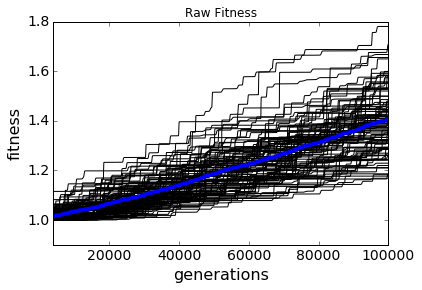

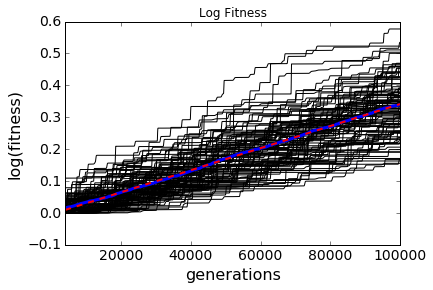

adaptation rate: 3.4572017090011395e-06
adaptation stdev:2.4981277460544275e-10


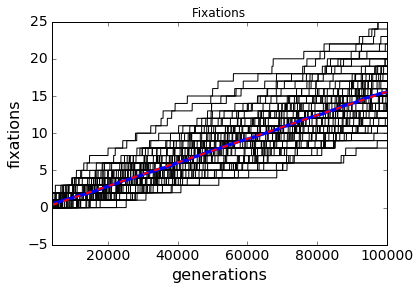

fixation rate: 0.00015843723717439697
fixation stdev:6.8543529826370014e-09


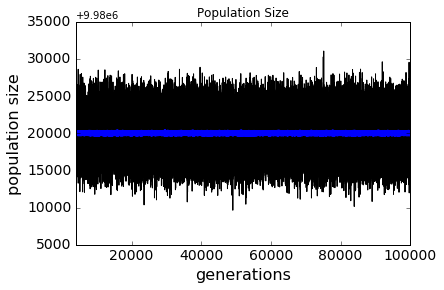

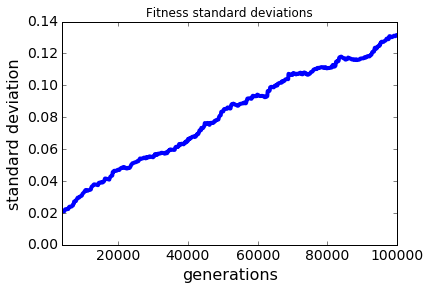

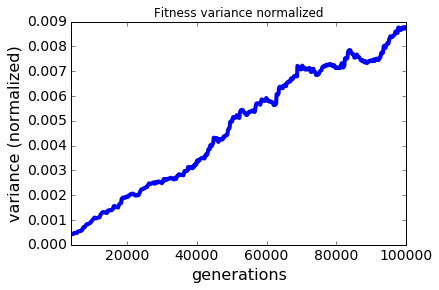

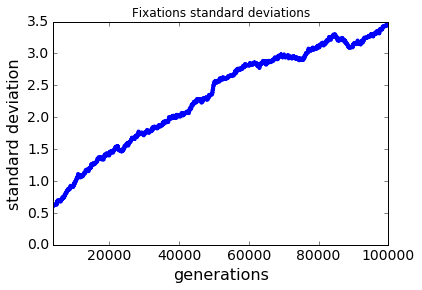

In [37]:
plotmin = lag #can be adjusted to show lag phase or to ignore lag phase
plotmax = num_gens #can be adjusted along with plot min to zoom in

_plot=pyplot.plot
_xticks=pyplot.xticks
_yticks=pyplot.yticks
_xlabel=pyplot.xlabel
_ylabel=pyplot.ylabel
_title=pyplot.title
_xlim=pyplot.xlim
_show=pyplot.show

_plot(fitness_trajectories[0:plotmax],'k'), _plot(mean_fitness_trajectory[0:plotmax], 'b', linewidth=4)
_xticks(size=14), _yticks(size=14), _xlabel("generations", size=16), _ylabel("fitness", size=16)
_title("Raw Fitness")
_xlim(plotmin,plotmax)
_show();

_plot(np.log(fitness_trajectories[0:plotmax]),'k'), _plot(np.log(mean_fitness_trajectory[0:plotmax]), 'b', linewidth=3)
_plot(log_fitness_y_vals[0:plotmax],'r--',linewidth=2)
_xticks(size=14), _yticks(size=14), _xlabel("generations", size=16), _ylabel("log(fitness)", size=16)
_title("Log Fitness")
_xlim(plotmin,plotmax)
_show();
adaptation_rate=slope_log_fit
print ("adaptation rate: " + `adaptation_rate`)
print ("adaptation stdev:" + `np.sqrt(np.diag(cov_fitness))[0]`)

_plot(fixation_trajectories[0:plotmax],'k'), _plot(mean_fixation_trajectory[0:plotmax], 'b', linewidth=3)
_plot(fixation_y_vals[0:plotmax],'r--',linewidth=2)
_xticks(size=14), _yticks(size=14), _xlabel("generations", size=16), _ylabel("fixations", size=16)
_title("Fixations")
_xlim(plotmin,plotmax)
_show();
fixation_rate=slope_fixation
print ("fixation rate: " + `fixation_rate`)
print ("fixation stdev:" + `np.sqrt(np.diag(cov_fixation))[0]`)

_plot(pop_size_trajectories[0:plotmax],'k'), _plot(mean_pop_size_trajectory[0:plotmax],'b', linewidth=4)
_xticks(size=14), _yticks(size=14), _xlabel("generations", size=16), _ylabel("population size", size=16)
_title("Population Size")
_xlim(plotmin,plotmax)
_show();

_plot(fitness_stand_devs[0:plotmax],'b', linewidth=4)
_xticks(size=14), _yticks(size=14),_xlabel("generations",size=16),_ylabel("standard deviation",size=16)
_title("Fitness standard deviations")
_xlim(plotmin,plotmax)
_show();

_plot([(x/y)**2 for x,y in izip(fitness_stand_devs[0:plotmax],mean_fitness_trajectory[0:plotmax])],'b', linewidth=4)
_xticks(size=14), _yticks(size=14),_xlabel("generations",size=16),_ylabel("variance (normalized)",size=16)
_title("Fitness variance normalized")
_xlim(plotmin,plotmax)
_show();

_plot(fixation_stand_devs[0:plotmax],'b', linewidth=4)
_xticks(size=14), _yticks(size=14),_xlabel("generations",size=16),_ylabel("standard deviation",size=16)
_title("Fixations standard deviations")
_xlim(plotmin,plotmax)
_show();

In [50]:
def intersect_many_lists(all_lists):    
    last_mutation_number=(len(new_master_mut)) #So that python doesn't waste time taking the length every time
    fixed_mutations=all_lists[0][:] #starts as all mutations in the first list, mutations are removed as they are found to be not fixations
    stop=False
    breaker=False
    removed=False
    for mutation_being_checked in fixed_mutations: #loops over the mutations in the first list
        i=0
        stop=False
        removed=False
        for x in range(1,len(all_lists)):#loops over every genotype in all_lists         
            if (breaker==True):
                break
            i=0
            genotype_being_checked =all_lists[x] 
            stop=False
            
            while ((stop==False)&(i<len(genotype_being_checked))): #loops until the mutation ID is found or not
                if genotype_being_checked[i]<mutation_being_checked: #if mutation number is less than what we're looking for
                    i=i+1 #then keep looking in this genotype
                elif genotype_being_checked[i]== mutation_being_checked: #if the mutation is found in this genotype, then move
                    stop=True #on to the next one
                elif genotype_being_checked[i]>mutation_being_checked: #if mutation is greater than the one we're looking for
                    if (removed==False):                      
                        fixed_mutations.remove(mutation_being_checked) #then it will not be in this genotype, and it will not be a 
                    removed=True
                    x=len(all_lists)+1 #fixation, so move on to the next mutation in the first element
                    stop=True
                    breaker=True
        
    return fixed_mutations        

In [6]:
def old_intersect_method(all_lists):
    #print(all_lists)
    if (len(all_lists)!=0): 
        f_muts = set(all_lists[0]) 
        for i in all_lists[1:]: 
            f_muts.intersection_update(i)
        output = list(f_muts)
        output.sort()
    return (output)

In [6]:
#plots histograms to see what types of mutations will fix
fixed_muts = set(new_mut_tracker[0])
for i in new_mut_tracker[1:]:
    fixed_muts.intersection_update(i)
fixed_muts = list(fixed_muts)

fixed_mut_sizes = [new_master_mut[x] for x in fixed_muts]
fixed_mut_back_sizes = [new_master_mut_background[x] for x in fixed_muts]

plt.hist(fixed_mut_sizes,20);



calculation = 2*adaptation_rate*log(pop_size/2)

plt.hist(fixed_mut_back_sizes,20); #currently plots them on top of each other, change later


IndexError: list index out of range

In [11]:
#CSV WRITER
import csv


pop_exponent = int(np.log10(pop_size))
pop_string = pop_size/(10**pop_exponent)
generic_file_name="_"+`pop_string`+"e"+`pop_exponent`+"_"+`alpha`+"_"+`mut_rate`  #this allows us to
#potentially loop over multiple files if we need to
file_number=1

error_message="Warning, a file you are trying to write to already exists.  If you would like to" +'\n' \
               + "overwrite, then set the \'can_overwrite\' tag to \'True\'" + '\n' \
               +"File was: "
can_overwrite=True
#sets whether or not you are allowed to overwrite existing files

#All the data
file_name = `file_number`+ "_" +"fitness"+generic_file_name+".csv"
if (((os.path.isfile(file_name)==False) or (can_overwrite==True))): #Checks if the file already exists
    with open(file_name, 'wb') as csvfile:
        outwriter = csv.writer(csvfile, delimiter=',',
                                quotechar=' ', quoting=csv.QUOTE_MINIMAL)
        for i in xrange(num_gens):
            outwriter.writerow(fitness_trajectories[i].tolist())
else:
    print (error_message+file_name)
        
file_name=`file_number`+ "_"+"fixation"+generic_file_name+".csv"
if (((os.path.isfile(file_name)==False) or (can_overwrite==True)) ):
    with open(file_name,'wb') as csvfile:
        outwriter = csv.writer(csvfile, delimiter=',',
                                quotechar=' ', quoting=csv.QUOTE_MINIMAL)
        for i in xrange(num_gens):
            outwriter.writerow(fixation_trajectories[i].tolist())
else:
    print (error_message+file_name)

file_name = `file_number`+ "_"+"pop_size"+generic_file_name+".csv"#this could get the axe
if (((os.path.isfile(file_name)==False) or (can_overwrite==True))):
    with open(file_name,'wb') as csvfile:
        outwriter = csv.writer(csvfile, delimiter=',',
                                quotechar=' ', quoting=csv.QUOTE_MINIMAL)
        for i in xrange(num_gens):
            outwriter.writerow(pop_size_trajectories[i].tolist())
else:
    print (error_message+file_name)        

#means
file_name=`file_number`+ "_"+"mean_data"+generic_file_name+".csv"
if (((os.path.isfile(file_name)==False) or (can_overwrite==True))):
    with open(file_name,'wb') as csvfile:
        outwriter = csv.writer(csvfile, delimiter=',',
                                quotechar=' ', quoting=csv.QUOTE_MINIMAL)
        for i in xrange(num_gens):
            outwriter.writerow([mean_fitness_trajectory[i],mean_fixation_trajectory[i],fitness_stand_devs[i],fixation_stand_devs[i]])
else:
    print (error_message+file_name)            
#rates
file_name=`file_number`+ "_"+"rates"+generic_file_name+".csv"
if (((os.path.isfile(file_name)==False) or (can_overwrite==True))):
    with open(file_name,'wb') as csvfile:
        outwriter = csv.writer(csvfile, delimiter=',',
                                quotechar=' ', quoting=csv.QUOTE_MINIMAL)
        outwriter.writerow(["adaptation rate: ",adaptation_rate])
        outwriter.writerow(["fixation rate: ",fixation_rate])
else:
    print (error_message+file_name)
    
#mutation tracker
#concatenates the fixed mutation effect sizes of all the runs
if (mutation_tracker_toggle==True):
    file_name =`file_number`+"_"+"mutation_tracker"+generic_file_name+".csv"
    if (((os.path.isfile(file_name)==False) or (can_overwrite==True))):
        with open(file_name,'wb') as csvfile:
            outwriter = csv.writer(csvfile, delimiter=',',
                                    quotechar=' ', quoting=csv.QUOTE_MINIMAL)
            outwriter.writerow(["Fixed Mutations","Fixed Mutations w/ Background"])
            for i in xrange(len(fixed_muts_trajectory)):
                outwriter.writerow([fixed_muts_trajectory[i],fixed_mut_back_trajectory[i]])
    else:
        print (error_message+file_name)